Lambda School Data Science, Unit 2: Predictive Modeling

# Applied Modeling, Module 3

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your work.

- [ ] Continue to iterate on your project: data cleaning, exploration, feature engineering, modeling.
- [ ] Make at least 1 partial dependence plot to explain your model.
- [ ] Share at least 1 visualization on Slack.

(If you have not yet completed an initial model yet for your portfolio project, then do today's assignment using your Tanzania Waterpumps model.)

## Stretch Goals
- [ ] Make multiple PDPs with 1 feature in isolation.
- [ ] Make multiple PDPs with 2 features in interaction.
- [ ] If you log-transformed your regression target, then convert your PDP back to original units. 
- [ ] Use Plotly to make a 3D PDP.
- [ ] Make PDPs with categorical feature(s). Use Ordinal Encoder, outside of a pipeline, to encode your data first. If there is a natural ordering, then take the time to encode it that way, instead of random integers. Then use the encoded data with pdpbox.I Get readable category names on your plot, instead of integer category codes.

## Links
- [Christoph Molnar: Interpretable Machine Learning — Partial Dependence Plots](https://christophm.github.io/interpretable-ml-book/pdp.html) + [animated explanation](https://twitter.com/ChristophMolnar/status/1066398522608635904)
- [Kaggle / Dan Becker: Machine Learning Explainability — Partial Dependence Plots](https://www.kaggle.com/dansbecker/partial-plots)
- [Plotly: 3D PDP example](https://plot.ly/scikit-learn/plot-partial-dependence/#partial-dependence-of-house-value-on-median-age-and-average-occupancy)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly_express as px
import seaborn as sns

In [3]:
df = pd.read_csv('CA_Hosp_Mortality.csv', encoding = "ISO-8859-1")

pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [4]:
# Cleaning function

def wrangle(X):
    
    X = X.copy()
    
    X = X.drop(columns='OSHPDID')
    # Change column names to more appropriate names without caps
    X = X.rename(columns={'YEAR':'Year', 'COUNTY':'County', 'HOSPITAL':'Hospital',
                        'Procedure/Condition':'Procedure_Condition',
                        'Risk Adjuested Mortality Rate':'RAMR', '# of Deaths':'Number_Deaths',
                        '# of Cases':'Number_Cases', 'Hospital Ratings':'Hospital_Ratings',
                        'LONGITUDE':'Longitude', 'LATITUDE':'Latitude'
                       })  
    
    # Remove rows where the value is for the entire state
    X = X.query("County != 'AAAA'") # AAAA is county code for State

    # Remove procedures that are not in every year and hidden NaN values
    X.replace({'AAA Repair':np.nan, 'AAA Repair Unruptured':np.nan, '.':np.nan}, inplace=True)
    X.dropna(inplace=True)
    
    # Change numeric columns from string to float
    numerics = ['RAMR', 'Number_Deaths', 'Number_Cases']
    for column in numerics:
        X[column] = X[column].astype(float)
    
    # Creating numeric values for hospital rating since it is in least to best
    X['Hospital_Ratings'].replace({'Worse':1, 'As Expected':2, 'Better':3}, inplace=True)
    
    return X

newdf = wrangle(df)

In [5]:
target = 'Number_Deaths'
features = newdf.columns.drop('Number_Deaths').tolist()

train = newdf.query('Year < 2014')
val = newdf.query('Year == 2014')
test = newdf.query('Year == 2015')

X_train = train[features]
y_train = train[target]

X_val = val[features]
y_val = val[target]

X_test = test[features]
y_test = test[target]

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((5882, 9), (5882,), (3267, 9), (3267,), (3130, 9), (3130,))

In [6]:
# XGBoost
# Tested XGBoost with numerical features only and with OrdinalEncoding of categoricals
# Numeric only: R^2 0.85, encoding: R^2 0.87
from sklearn.metrics import r2_score
from xgboost import XGBRegressor
from sklearn.pipeline import make_pipeline
import category_encoders as ce

gb = make_pipeline(
    ce.OrdinalEncoder(),
    XGBRegressor(n_estimators=200, objective='reg:squarederror', n_jobs=-1)
    )

# Only used when testing out no encoding
# X_train_numeric = X_train.select_dtypes(include='number')
# X_val_numeric = X_val.select_dtypes(include='number')

gb.fit(X_train, y_train)
y_pred = gb.predict(X_val)
print('Gradient Boosting R^2:', r2_score(y_val, y_pred))

Gradient Boosting R^2: 0.8703073436811183


In [7]:
# RandomizedSearchCV to find best hyperparams for the XGBoost
from scipy.stats import randint, uniform
from sklearn.model_selection import RandomizedSearchCV
gb_early = make_pipeline(
            ce.OrdinalEncoder(),
            XGBRegressor(objective='reg:squarederror', random_state=42)
)

param_distributions = {
    'xgbregressor__n_estimators': randint(100,1000),
    'xgbregressor__max_depth':randint(3, 10),
    'xgbregressor__learningrate': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]
}

search = RandomizedSearchCV(
    gb_early,
    param_distributions,
    n_iter=5,
    cv=2,
    scoring='neg_mean_absolute_error',
    verbose=10,
    return_train_score=True,
    n_jobs=-1
)

search.fit(X_train, y_train);

Fitting 2 folds for each of 5 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:   12.0s remaining:   12.0s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:   13.9s remaining:    5.9s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   14.6s finished


In [8]:
# Repeat XGBoost with best hyper params

gb = make_pipeline(
    ce.OrdinalEncoder(),
    XGBRegressor(n_estimators=300, objective='reg:squarederror',n_jobs=-1, learningrate=0.1, max_depth=7)
    )

gb.fit(X_train, y_train)
y_pred = gb.predict(X_val)
print('Gradient Boosting R^2:', r2_score(y_val, y_pred))

Gradient Boosting R^2: 0.8684565084383491


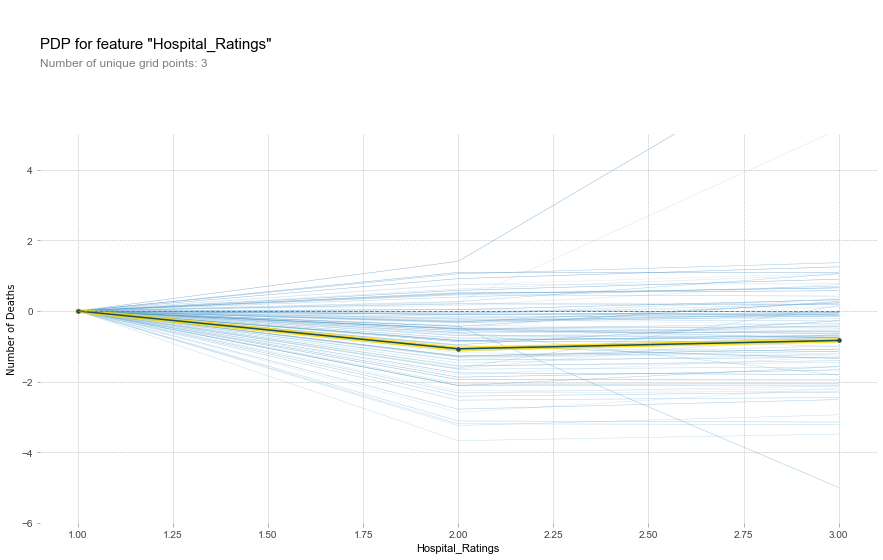

In [9]:
# Partial Dependence Plot - Hospital Rating

import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 72

from pdpbox.pdp import pdp_isolate, pdp_plot

feature = 'Hospital_Ratings'

isolated = pdp_isolate(
    model = gb,
    dataset=X_val,
    model_features=X_val.columns,
    feature=feature
)

pdp_plot(isolated, feature_name=feature, plot_lines=True, frac_to_plot=100)
plt.ylabel('Number of Deaths')
plt.ylim(-6, 5);